In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import nashpy as nash
import math as math
import itertools as itertools
from operator import add, neg
from matplotlib.ticker import FixedLocator, FixedFormatter,AutoMinorLocator

# Diverse functions for the case with n=2 locations

In [2]:
def value_matrix_vertex(A): #return the value of the game and the optimal strategies given a payoff matrix
    game=nash.Game(A)
    columnP=[] #default value
    for eq in game.vertex_enumeration(): 
        columnP=eq[1] 
        columnS=eq[0]
    H_prob=np.around(columnP, decimals=3)
    S_prob=np.around(columnS, decimals=3)
    if list(columnP):
        value=max(np.dot(columnP,A[k,:]) for k in range(A.shape[0]))
    else:
        print("no eq")
        value=A[0,0]
    return(value,H_prob,S_prob)

class H_k(): #a first (and generic) way to iteratively compute the values
    def __init__(self, n,k,p):
        self.n=n
        self.k=k
        self.p=p #Vecteur proba 
        self.matrixk=np.asarray([[0.0 for i in range(n)] for j in range(math.factorial(n))])#Matrix de float sinon arrondi à 0...
        self.matrixid=np.asarray([[0.0 for i in range(n)] for j in range(math.factorial(n))])#Matrix de float sinon arrondi à 0...
        self.permut=list(itertools.permutations(list(range(1, self.n+1))))
        self.signmatrixk=np.asarray([[-1.0 for i in range(n)] for j in range(math.factorial(n))])
        self.tractablematrix=[]
        
    def column_index(self,val_list):
        for idx,perm in enumerate(self.permut):
            for cachette in range(self.n): 
                self.matrixid[idx][cachette]=list(perm).index(cachette+1)+1 
                if self.matrixid[idx][cachette]>self.k:
                    self.signmatrixk[idx][cachette]=0   
                else:
                    P=self.p[cachette] 
                    value=max(0,int(self.k-self.matrixid[idx][cachette]))
                    self.signmatrixk[idx][cachette]=P +(1-P)*val_list[value] 
        self.tractablematrix=np.copy(self.signmatrixk)
        self.signmatrixk=np.flip(np.unique(self.signmatrixk, axis=0),0)
        V,H_prob,S_prob=value_matrix_vertex(self.signmatrixk)
        return V,H_prob,S_prob
    
class gamma_game(): #a second (and specific to the case n=2 locations) way to iteratively compute the values, as described in SUpplementary Materials
    
    def __init__(self,b,c):
        self.b = b
        self.c = c
        self.values=[0, (b*c)/(b+c)]
        self.Gammaori=[k for k in range(10)]
        self.GammaX=[]
        self.GammaY=[]
        self.diffs=[]

    def function_phi(self,Phi): 
        moinsun=Phi[0] #x
        zero=Phi[1] #y
        Aa= self.b+(1-self.b)*zero
        Ab= self.c+(1-self.c)*moinsun
        Ac= self.b+(1-self.b)*moinsun
        Ad= self.c+(1-self.c)*zero
        Akplusun=np.array([[Aa,Ab],[Ac,Ad]])
        if Aa<=Ab: 
            self.values=[zero, Aa] 
        else:
            detmatrixA=np.linalg.det(Akplusun)
            SmatrixA=Aa + Ad - Ab - Ac
            value_Akplusun=detmatrixA/SmatrixA
            self.values=[zero,value_Akplusun]
        return self.values 
    
    def boundary(self,npoints):
        GammalineX=np.linspace(0,1,npoints)
        GammalineY=[(1-self.c)*GammalineX[k]/(1-self.b)+(self.c-self.b)/(1-self.b) for k in range(npoints)]
        GammaMatchY=[(1-self.c)*self.GammaX[k]/(1-self.b)+(self.c-self.b)/(1-self.b) for k in range(len(self.GammaX))]
        return GammalineX,GammalineY,GammaMatchY
    
    def iterate_values(self,iterations):
        for k in range(iterations):
            self.GammaX+=[self.values[0]]
            self.GammaY+=[self.values[1]]
            self.function_phi(self.values)
    
    def plot_values(self, plot1,plot2, axe, symbol,color):
        self.diffs=[self.boundary(50)[2][k] - self.GammaY[k] for k in range (len(self.GammaY))]
        #en dehors d ela boucle
        
        if plot1==True:
            axe.set_xlim([0,1])
            axe.set_ylim([0,1])
            axe.plot(self.GammaX, self.GammaY,marker=symbol,color=color,linewidth=0) 
            axe.plot(self.boundary(50)[0], self.boundary(50)[0], color='black', linestyle='-', label =r'$v_{m-1} =v_{m-2}$', alpha=1)
            axe.plot(self.GammaX,self.boundary(50)[2],color='black', linestyle='--',label=r'$v_{m-1} = \frac{1-c}{1-b} v_{m-2} + \frac{c-b}{1-b}$',alpha=1)
            axe.fill_between(self.GammaX, self.GammaX, self.boundary(50)[2], color='gainsboro')
            axe.fill_between(self.GammaX, np.repeat(1, len(self.GammaX)), self.boundary(50)[2], color='whitesmoke')
            
        if plot2==True:
            axe.set_xlim([0,1])
            axe.set_ylim([-0.5,0.5])
            axe.plot(self.GammaX, self.diffs)
            axe.plot(self.GammaX, np.repeat(0, len(self.GammaX)),'--',color='black')
    
    def plot_val(self,iterations,color):
        plt.xlim([-5,iterations])
        plt.ylim([0,1])
        plt.plot(np.linspace(0,iterations-1,iterations), self.GammaX[:],'-',color) 

def function_g(x): #Compute boundaries
    y=[]
    for b in x:
        delta=b**2 - 2*b + 5
        g=b*(1-b + np.sqrt(delta))/2
        y+=[g]
    return y

def function_gter(x): #Compute boundaries
    y=[]
    for b in x:
        g=2*b-b**2
        y+=[g]
    return y


def domains(c,title, axe, symbol,color):  #Plot v(m-1) as a function of v(m-2) for a given c. 
    G=G=gamma_game(b,c) 
    coeff=(1-c)/(1-b)
    inter=(c-b)/(1-b)
    G.iterate_values(10)
    G.plot_values(True,False, axe, symbol,color) 
    axe.set_title(title, color=color, fontsize=15)
    axe.set_xlabel('v(m-2)', fontsize=15)
    axe.set_ylabel('v(m-1)', fontsize=15)
    axe.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
    axe.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
    axe.scatter(0,0,marker='o', color='gainsboro',label=r' (Pure Strategy)') 
    axe.scatter(0,0,marker='o',s=90,color='whitesmoke',label=r'(Mixed Strategy)') 
    axe.legend(loc=4,prop={'size':15}, frameon=False)
    
def hstrats(probas,colors,axe0,axe1): #Plot the optimal strategies. Arguments: probabilities (list), graphical arguments
    maxiter=9 
    values=[0]
    Hprobas=np.zeros((len(probas),maxiter))
    Sprobas=np.zeros((len(probas),maxiter))
    
    for k in range(1,maxiter):
        G=H_k(len(probas),k,probas)
        V,H_prob,S_prob=G.column_index(values)
        values+=[V]
        Hprobas[:,k]=H_prob
        Sprobas[:,k]=S_prob
    axe0.plot(Hprobas[0,1:], color=colors, linestyle='-')
    axe0.plot(Hprobas[1,1:], color=colors, linestyle='--', alpha=0.5)
    axe1.plot(Sprobas[0,1:], color=colors, linestyle='-')
    axe1.plot(Sprobas[1,1:], color=colors, linestyle='--', alpha=0.5)    
    axe0.set_xticklabels([-1,1,2,3,4,5,6,7,8],fontsize=15)
    axe0.set_yticklabels([-1,0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
    axe1.set_xticklabels([-1,1,2,3,4,5,6,7,8],fontsize=15)
    axe1.set_yticklabels([-1,0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
    axe0.set_ylim([-0.01,1.01])
    axe0.set_xlabel('m looks', fontsize=15)
    axe0.set_ylabel(r'hiding probabilities $h_1$ and $h_2$', fontsize=15)
    axe0.spines['right'].set_visible(False)
    axe0.spines['top'].set_visible(False) 
    axe1.set_ylim([-0.01,1.01])
    axe1.set_xlabel('m looks', fontsize=15)
    axe1.set_ylabel(r'searching probabilities $s_{12}$ and $s_{21}$', fontsize=15)
    axe1.spines['right'].set_visible(False)
    axe1.spines['top'].set_visible(False) 
    axe0.plot([2,2],[-1,-1], linestyle='-', color='black', label=r'$h_1$')
    axe0.plot([2,2],[-1,-1], linestyle='--', color='black', label=r'$h_2$')
    axe1.plot([2,2],[-1,-1], linestyle='-', color='black', label=r'$s_{12}$')
    axe1.plot([2,2],[-1,-1], linestyle='--', color='black', label=r'$s_{21}$')
    axe0.legend(loc=4,prop={'size':15}, frameon=False, ncol=2)
    axe1.legend(loc=4,prop={'size':15}, frameon=False, ncol=2)
    
  

# Supplementary Figure: Plots v(m-1) = f(v(m_2)) 

C:\Users\PaulWork\AppData\Local\Temp/ipykernel_10780/4242552449.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
C:\Users\PaulWork\AppData\Local\Temp/ipykernel_10780/4242552449.py:132: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
C:\Users\PaulWork\AppData\Local\Temp/ipykernel_10780/4242552449.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
C:\Users\PaulWork\AppData\Local\Temp/ipykernel_10780/4242552449.py:132: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
C:\Users\PaulWork\AppData\Local\Temp/ipykernel_10780/4242552449.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe.set

Text(0.02, 0.95, 'c.')

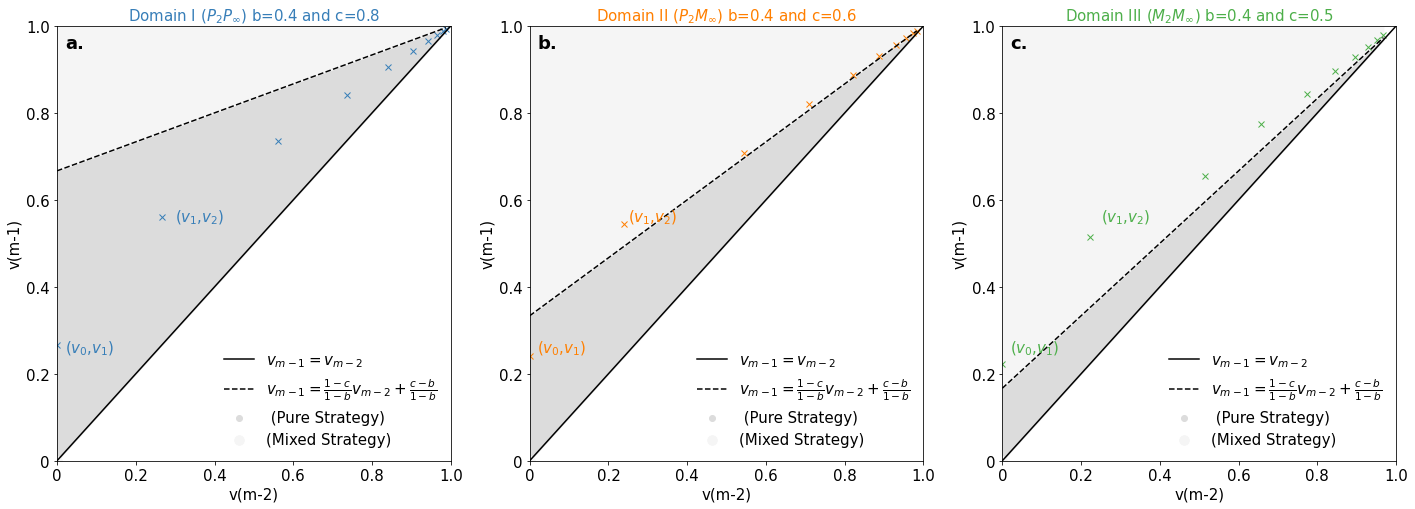

In [3]:
b=0.4
colors=['#377eb8', '#ff7f00', '#4daf4a']

fig,ax = plt.subplots(figsize=(24,8))
ax1=plt.subplot2grid((1,3),(0,0))
ax2=plt.subplot2grid((1,3),(0,1))
ax3=plt.subplot2grid((1,3),(0,2))

#Plots v(m-1) as a function of v(m-2) for three representative pairs
domains(0.5, r'Domain III ($M_{2}M_{\infty}$) b=0.4 and c=0.5',ax3, 'x',color=colors[2])
domains(0.6, r'Domain II ($P_{2}M_{\infty}$) b=0.4 and c=0.6',ax2, 'x',color=colors[1])
domains(0.8, r'Domain I ($P_{2}P_{\infty}$) b=0.4 and c=0.8',ax1, 'x',color=colors[0])

ax3.text(0.02,0.25,r'($v_0$,$v_1$)', fontsize=15, color=colors[2])
ax3.text(0.25,0.55,r'($v_1$,$v_2$)', fontsize=15, color=colors[2])
ax2.text(0.02,0.25,r'($v_0$,$v_1$)', fontsize=15, color=colors[1])
ax2.text(0.25,0.55,r'($v_1$,$v_2$)', fontsize=15, color=colors[1])
ax1.text(0.02,0.25,r'($v_0$,$v_1$)', fontsize=15, color=colors[0])
ax1.text(0.3,0.55,r'($v_1$,$v_2$)', fontsize=15, color=colors[0])
ax1.text(0.02,0.95,"a.", fontsize=18,fontweight='bold',  transform=ax1.transAxes)
ax2.text(0.02,0.95,"b.", fontsize=18,fontweight='bold',  transform=ax2.transAxes)
ax3.text(0.02,0.95,"c.", fontsize=18,fontweight='bold',  transform=ax3.transAxes)

# Figure 2 of the paper

C:\Users\PaulWork\AppData\Local\Temp/ipykernel_10780/561768424.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels([-1, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
C:\Users\PaulWork\AppData\Local\Temp/ipykernel_10780/561768424.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_yticklabels([-1, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
C:\Users\PaulWork\AppData\Local\Temp/ipykernel_10780/4242552449.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe0.set_xticklabels([-1,1,2,3,4,5,6,7,8],fontsize=15)
C:\Users\PaulWork\AppData\Local\Temp/ipykernel_10780/4242552449.py:154: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe0.set_yticklabels([-1,0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
C:\Users\PaulWork\AppData\Local\Temp/ipykernel_10780/4242552449.py:155: UserWarning: FixedFormatter should only be used together with FixedLocator
  

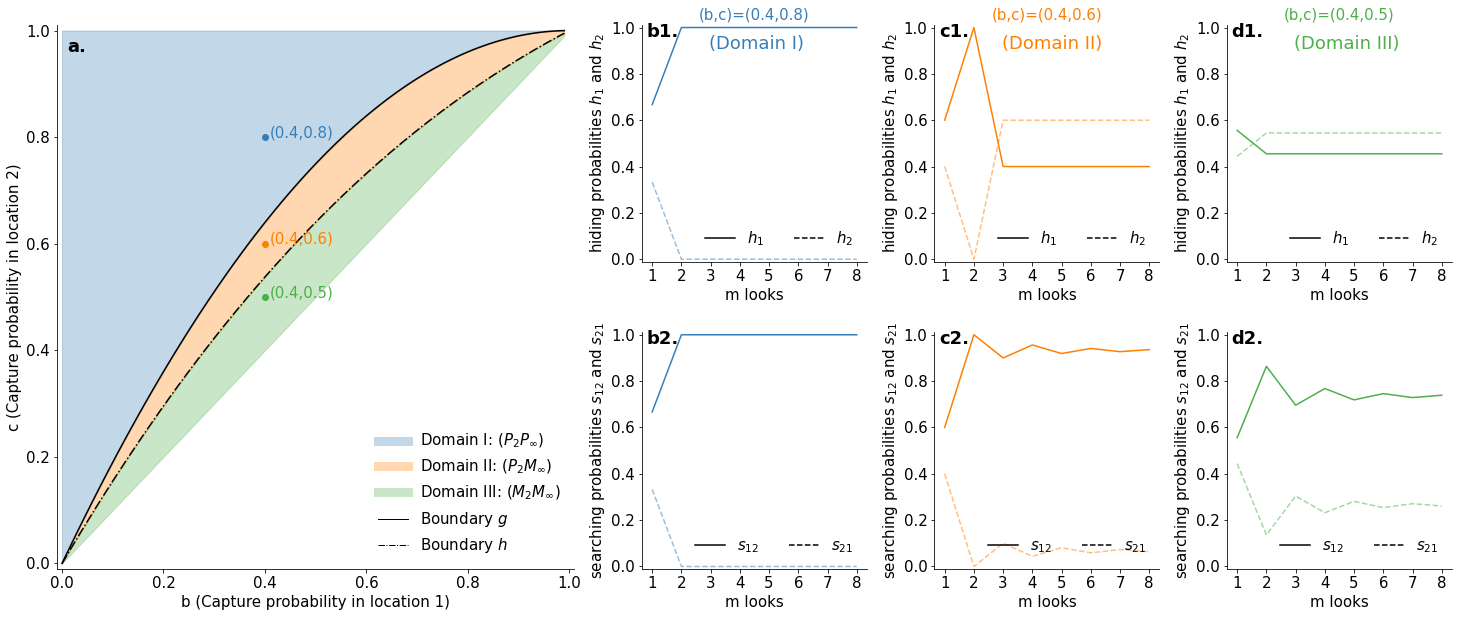

In [4]:
b=0.4
startb=0
incrb=0.01
maxb= int((1-startb)/incrb)  
listb=[startb+k*incrb for k in range(maxb)]

# Graphics
colors=['#377eb8', '#ff7f00', '#4daf4a']
fig,ax = plt.subplots(figsize=(25,10))
ax4=plt.subplot2grid((2,5),(0,0), colspan=2, rowspan=2)
ax5=plt.subplot2grid((2,5),(0,2))
ax6=plt.subplot2grid((2,5),(0,3))
ax7=plt.subplot2grid((2,5),(0,4))
ax8=plt.subplot2grid((2,5),(1,2))
ax9=plt.subplot2grid((2,5),(1,3))
ax10=plt.subplot2grid((2,5),(1,4))


#Plot the (b,c) space and the boundaries
y1=function_g(listb)
y2=function_gter(listb)
y3=listb
y4=np.repeat(1, len(listb))
ax4.plot(listb, y1, color='black', linestyle='-.') #, label=r'$ c= b(1-b+\sqrt{b^2 - 2b +5})/2$'
ax4.plot(listb, y2 , color='black', linestyle='-') #, label=r'$ c= 2b - b^2$'
ax4.set_xlabel('b (Capture probability in location 1)', fontsize=15)
ax4.set_ylabel('c (Capture probability in location 2)', fontsize=15)
ax4.fill_between(listb, y2, y4, color=colors[0], alpha=0.3)
ax4.fill_between(listb, y1, y2, color=colors[1], alpha=0.3)
ax4.fill_between(listb, y1, y3, color=colors[2], alpha=0.3)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)            
ax4.set_xticklabels([-1, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
ax4.set_yticklabels([-1, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)

#Plot representative pairs of points
ax4.scatter(0.4,0.8, marker='o', color=colors[0])
ax4.scatter(0.4,0.6, marker='o', color=colors[1])
ax4.scatter(0.4,0.5, marker='o', color=colors[2])

#Plot hiding and searching strategies
hstrats([0.4,0.8],colors[0],ax5,ax8)
hstrats([0.4,0.6],colors[1],ax6,ax9)
hstrats([0.4,0.5],colors[2],ax7,ax10)

#Add text and annotations
eps=0.01
ax4.text(0.4+eps,0.5,'(0.4,0.5)', color=colors[2],fontsize=15)
ax4.text(0.4+eps,0.6,'(0.4,0.6)', color=colors[1],fontsize=15)
ax4.text(0.4+eps,0.8,'(0.4,0.8)', color=colors[0],fontsize=15)
ax4.plot([2],[-1], linestyle='solid',linewidth=9, color=colors[0],alpha=0.3, label=r'Domain I: ($P_{2}P_{\infty}$)')
ax4.plot([2],[-1], linestyle='solid',linewidth=9, color=colors[1],alpha=0.3, label=r'Domain II: ($P_{2}M_{\infty}$)')
ax4.plot([2],[-1], linestyle='solid',linewidth=9, color=colors[2],alpha=0.3, label=r'Domain III: ($M_{2}M_{\infty}$)')
ax4.plot([2],[-1], linestyle='solid',linewidth=1, color='black', label=r'Boundary $g$')
ax4.plot([2],[-1], linestyle='-.',linewidth=1, color='black', label=r'Boundary $h$')
ax4.set_xlim([-0.01,1.01])
ax4.set_ylim([-0.01,1.01])
ax4.legend(loc=4,prop={'size':15}, frameon=False)
ax5.set_title('(b,c)=(0.4,0.8)',fontsize=15, color=colors[0])
ax6.set_title('(b,c)=(0.4,0.6)',fontsize=15, color=colors[1])
ax7.set_title('(b,c)=(0.4,0.5)',fontsize=15, color=colors[2])
ax4.text(0.02,0.95,"a.", fontsize=18,fontweight='bold',  transform=ax4.transAxes)
ax5.text(0.02,0.95,"b1.", fontsize=18,fontweight='bold',  transform=ax5.transAxes)
ax6.text(0.02,0.95,"c1.", fontsize=18,fontweight='bold',  transform=ax6.transAxes)
ax7.text(0.02,0.95,"d1.", fontsize=18,fontweight='bold',  transform=ax7.transAxes)
ax8.text(0.02,0.95,"b2.", fontsize=18,fontweight='bold',  transform=ax8.transAxes)
ax9.text(0.02,0.95,"c2.", fontsize=18,fontweight='bold',  transform=ax9.transAxes)
ax10.text(0.02,0.95,"d2.", fontsize=18,fontweight='bold',  transform=ax10.transAxes)
ax5.text(0.3,0.9,"(Domain I)", fontsize=18, color=colors[0], transform=ax5.transAxes)
ax6.text(0.3,0.9,"(Domain II)", fontsize=18, color=colors[1], transform=ax6.transAxes)
ax7.text(0.3,0.9,"(Domain III)", fontsize=18, color=colors[2],  transform=ax7.transAxes)

# Graphics
x_formatter = FixedFormatter([1,2,3,4,5,6,7,8,9])
x_locator = FixedLocator([0,1,2,3,4,5,6,7,8])
ax5.xaxis.set_major_formatter(x_formatter)
ax5.xaxis.set_major_locator(x_locator)
ax6.xaxis.set_major_formatter(x_formatter)
ax6.xaxis.set_major_locator(x_locator)
ax7.xaxis.set_major_formatter(x_formatter)
ax7.xaxis.set_major_locator(x_locator)
ax8.xaxis.set_major_formatter(x_formatter)
ax8.xaxis.set_major_locator(x_locator)
ax9.xaxis.set_major_formatter(x_formatter)
ax9.xaxis.set_major_locator(x_locator)
ax10.xaxis.set_major_formatter(x_formatter)
ax10.xaxis.set_major_locator(x_locator)

plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.show()